In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

def organize_dataset():
    # 设置源目录和目标目录
    source_dir = r'D:\dogs-vs-cats\train'  # 原始训练数据目录
    base_dir = r'D:\dogs-vs-cats\dataset'  # 整理后的数据集目录
    
    # 创建必要的目录
    for folder in ['train/cat', 'train/dog', 'valid/cat', 'valid/dog']:
        os.makedirs(os.path.join(base_dir, folder), exist_ok=True)
    
    # 获取所有图片文件
    cat_files = [f for f in os.listdir(source_dir) if f.startswith('cat')]
    dog_files = [f for f in os.listdir(source_dir) if f.startswith('dog')]
    
    # 分割训练集和验证集
    cat_train, cat_valid = train_test_split(cat_files, test_size=0.2, random_state=42)
    dog_train, dog_valid = train_test_split(dog_files, test_size=0.2, random_state=42)
    
    # 移动文件
    for fname in cat_train:
        shutil.copy(os.path.join(source_dir, fname), 
                   os.path.join(base_dir, 'train/cat', fname))
    for fname in dog_train:
        shutil.copy(os.path.join(source_dir, fname), 
                   os.path.join(base_dir, 'train/dog', fname))
    for fname in cat_valid:
        shutil.copy(os.path.join(source_dir, fname), 
                   os.path.join(base_dir, 'valid/cat', fname))
    for fname in dog_valid:
        shutil.copy(os.path.join(source_dir, fname), 
                   os.path.join(base_dir, 'valid/dog', fname))
    
    print("数据集组织完成！")
    print(f"训练集猫图片：{len(cat_train)}张")
    print(f"训练集狗图片：{len(dog_train)}张")
    print(f"验证集猫图片：{len(cat_valid)}张")
    print(f"验证集狗图片：{len(dog_valid)}张")

if __name__ == '__main__':
    organize_dataset() 

数据集组织完成！
训练集猫图片：10000张
训练集狗图片：10000张
验证集猫图片：2500张
验证集狗图片：2500张


In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# 定义数据预处理转换
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # 调整图片大小
    transforms.ToTensor(),            # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# 创建数据集
train_dataset = torchvision.datasets.ImageFolder(
    root='D:/dogs-vs-cats/dataset/train',
    transform=transform
)

valid_dataset = torchvision.datasets.ImageFolder(
    root='D:/dogs-vs-cats/dataset/valid',
    transform=transform
)

# 创建数据加载器
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=0  # 在Windows系统上，建议先设置为0
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=32, 
    shuffle=False,
    num_workers=0
)

In [3]:
# 检查数据集信息
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(valid_dataset)}")
print(f"类别映射: {train_dataset.class_to_idx}")

# 获取一个批次的数据并查看形状
for images, labels in train_loader:
    print(f"批次中图像的形状: {images.shape}")
    print(f"批次中标签的形状: {labels.shape}")
    break

# 检查是否可以使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

训练集大小: 20000
验证集大小: 5000
类别映射: {'cat': 0, 'dog': 1}
批次中图像的形状: torch.Size([32, 3, 224, 224])
批次中标签的形状: torch.Size([32])
使用设备: cuda


In [7]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        # 第一个卷积块
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )  # 输出: 32 x 112 x 112
        
        # 第二个卷积块
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )  # 输出: 64 x 56 x 56
        
        # 第三个卷积块
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )  # 输出: 128 x 28 x 28
        
        # 计算全连接层的输入特征数
        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),  # 128 * 28 * 28 = 100352
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv1(x)  # 224x224 -> 112x112
        x = self.conv2(x)  # 112x112 -> 56x56
        x = self.conv3(x)  # 56x56 -> 28x28
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc(x)
        return x

# 创建模型实例并移至GPU
model = CatDogCNN().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 打印模型结构
print(model)

CatDogCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropo

In [8]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    # 用于存储训练过程中的指标
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    best_valid_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 每100个批次打印一次训练状态
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        # 计算平均训练损失
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # 验证阶段
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # 计算验证集的平均损失和准确率
        epoch_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        accuracy = 100 * correct / total
        valid_accuracies.append(accuracy)
        
        # 打印epoch的训练结果
        print(f'Epoch [{epoch+1}/{num_epochs}] Summary:')
        print(f'Training Loss: {epoch_train_loss:.4f}')
        print(f'Validation Loss: {epoch_valid_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')
        print('-' * 60)
        
        # 保存最佳模型
        if accuracy > best_valid_accuracy:
            best_valid_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
    
    return train_losses, valid_losses, valid_accuracies

Epoch [1/10], Step [100/625], Loss: 0.7473
Epoch [1/10], Step [200/625], Loss: 0.5844
Epoch [1/10], Step [300/625], Loss: 0.6925
Epoch [1/10], Step [400/625], Loss: 0.5719
Epoch [1/10], Step [500/625], Loss: 0.7048
Epoch [1/10], Step [600/625], Loss: 0.6702
Epoch [1/10] Summary:
Training Loss: 1.2634
Validation Loss: 0.6231
Validation Accuracy: 63.60%
------------------------------------------------------------
Epoch [2/10], Step [100/625], Loss: 0.5803
Epoch [2/10], Step [200/625], Loss: 0.8321
Epoch [2/10], Step [300/625], Loss: 0.5777
Epoch [2/10], Step [400/625], Loss: 0.6682
Epoch [2/10], Step [500/625], Loss: 0.6991
Epoch [2/10], Step [600/625], Loss: 0.6976
Epoch [2/10] Summary:
Training Loss: 0.6101
Validation Loss: 0.5676
Validation Accuracy: 68.10%
------------------------------------------------------------
Epoch [3/10], Step [100/625], Loss: 0.5510
Epoch [3/10], Step [200/625], Loss: 0.6235
Epoch [3/10], Step [300/625], Loss: 0.6491
Epoch [3/10], Step [400/625], Loss: 0.639

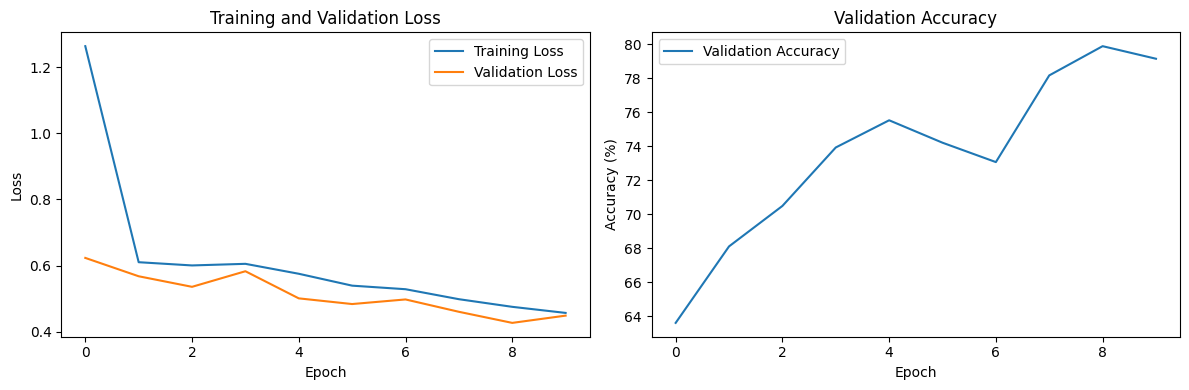

In [9]:
# 开始训练
num_epochs = 10
train_losses, valid_losses, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs
)

# 绘制训练过程
plt.figure(figsize=(12, 4))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

预测结果：这是一只猫
预测概率：70.31%


e:\Anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e

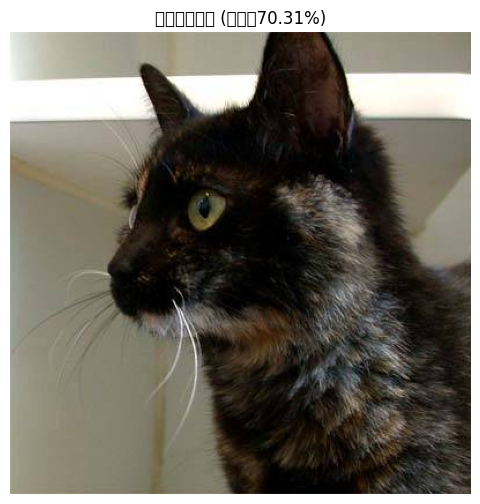

In [11]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def predict_image(image_path, model):
    # 确保模型处于评估模式
    model.eval()
    
    # 加载和预处理图像
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # 转换图像
    image_tensor = transform(image).unsqueeze(0)  # 添加批次维度
    
    # 将图像移到GPU（如果可用）
    image_tensor = image_tensor.to(device)
    
    # 预测
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
        
        # 获取概率
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
    # 获取预测结果和概率
    pred_class = "猫" if predicted.item() == 0 else "狗"
    prob = probabilities[0][predicted.item()].item()
    
    return pred_class, prob

# 使用示例
image_path = "D:/dogs-vs-cats/test1/5.jpg"  # 替换为你要测试的图片路径
pred_class, probability = predict_image(image_path, model)
print(f"预测结果：这是一只{pred_class}")
print(f"预测概率：{probability*100:.2f}%")

# 可以显示图片
plt.figure(figsize=(6, 6))
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.title(f'预测结果：{pred_class} (概率：{probability*100:.2f}%)')
plt.show()

## 尝试添加注意力机制来提高模型的准确性

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

# 指定使用的GPU设备
torch.cuda.set_device(0)  # 使用第一个GPU，如果有多个GPU，可以改为1,2等
cudnn.benchmark = True    # 为固定大小的输入启用cudnn加速

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
print(f"当前使用的GPU: {torch.cuda.get_device_name(0)}")

# 数据加载器优化
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=4,                # 增加工作进程数
    pin_memory=True,             # 将数据直接加载到GPU内存
    prefetch_factor=2,           # 预加载的batch数量
    persistent_workers=True      # 保持工作进程存活
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=32, 
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

使用设备: cuda
当前使用的GPU: NVIDIA GeForce GTX 1080


NameError: name 'train_dataset' is not defined

In [13]:
class AttentionCNN(nn.Module):
    def __init__(self):
        super(AttentionCNN, self).__init__()
        # 第一个卷积块
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )  # 输出: 32 x 112 x 112
        
        # 第二个卷积块
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )  # 输出: 64 x 56 x 56
        
        # 第三个卷积块
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )  # 输出: 128 x 28 x 28
        
        # 通道注意力机制
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 全局平均池化
            nn.Conv2d(128, 8, kernel_size=1),  # 降维
            nn.ReLU(),
            nn.Conv2d(8, 128, kernel_size=1),  # 升维
            nn.Sigmoid()
        )
        
        # 空间注意力机制
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        # 特征提取
        x = self.conv1(x)  # 224x224 -> 112x112
        x = self.conv2(x)  # 112x112 -> 56x56
        x = self.conv3(x)  # 56x56 -> 28x28
        
        # 通道注意力
        channel_weight = self.channel_attention(x)
        x = x * channel_weight
        
        # 空间注意力
        spatial_weight = self.spatial_attention(x)
        x = x * spatial_weight
        
        # 分类
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc(x)
        return x

In [14]:
# 修改训练函数以包含GPU内存管理
def train_attention_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=15):
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    best_valid_accuracy = 0.0
    
    # 打印初始GPU内存使用情况
    print(f"初始GPU内存分配: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)    # 非阻塞传输到GPU
            labels = labels.cuda(non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)  # 更高效的梯度清零
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'GPU内存: {torch.cuda.memory_allocated()/1024**2:.2f} MB')
                
                # 清理缓存
                torch.cuda.empty_cache()
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # 验证阶段
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        accuracy = 100 * correct / total
        valid_accuracies.append(accuracy)
        
        scheduler.step(epoch_valid_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Summary:')
        print(f'Training Loss: {epoch_train_loss:.4f}')
        print(f'Validation Loss: {epoch_valid_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')
        print(f'GPU内存: {torch.cuda.memory_allocated()/1024**2:.2f} MB')
        print('-' * 60)
        
        # 保存最佳模型
        if accuracy > best_valid_accuracy:
            best_valid_accuracy = accuracy
            torch.save(model.state_dict(), 'best_attention_model.pth')
        
        # 清理GPU缓存
        torch.cuda.empty_cache()
    
    return train_losses, valid_losses, valid_accuracies

In [15]:
# 创建模型并移至GPU
model = AttentionCNN()
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  # 如果有多个GPU，使用数据并行
model = model.cuda()

# 优化器和损失函数
criterion = nn.CrossEntropyLoss().cuda()  # 将损失函数移至GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)



# 开始训练
print("开始训练...")
print(f"GPU设备数量: {torch.cuda.device_count()}")
print(f"当前GPU内存使用: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

num_epochs = 15
train_losses, valid_losses, valid_accuracies = train_attention_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs
)

e:\Anaconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


开始训练...
GPU设备数量: 1
当前GPU内存使用: 605.39 MB
初始GPU内存分配: 605.39 MB
Epoch [1/15], Step [100/625], Loss: 0.6935, GPU内存: 1212.96 MB
Epoch [1/15], Step [200/625], Loss: 0.6909, GPU内存: 1212.96 MB
Epoch [1/15], Step [300/625], Loss: 0.6579, GPU内存: 1212.96 MB
Epoch [1/15], Step [400/625], Loss: 0.6795, GPU内存: 1212.96 MB
Epoch [1/15], Step [500/625], Loss: 0.5875, GPU内存: 1212.96 MB
Epoch [1/15], Step [600/625], Loss: 0.6021, GPU内存: 1212.96 MB
Epoch [1/15] Summary:
Training Loss: 0.7672
Validation Loss: 0.6473
Validation Accuracy: 65.56%
GPU内存: 1199.18 MB
------------------------------------------------------------
Epoch [2/15], Step [100/625], Loss: 0.5468, GPU内存: 1212.96 MB
Epoch [2/15], Step [200/625], Loss: 0.5975, GPU内存: 1212.96 MB
Epoch [2/15], Step [300/625], Loss: 0.5695, GPU内存: 1212.96 MB
Epoch [2/15], Step [400/625], Loss: 0.5243, GPU内存: 1212.96 MB
Epoch [2/15], Step [500/625], Loss: 0.6702, GPU内存: 1212.96 MB
Epoch [2/15], Step [600/625], Loss: 0.5118, GPU内存: 1212.96 MB
Epoch [2/15] Summary

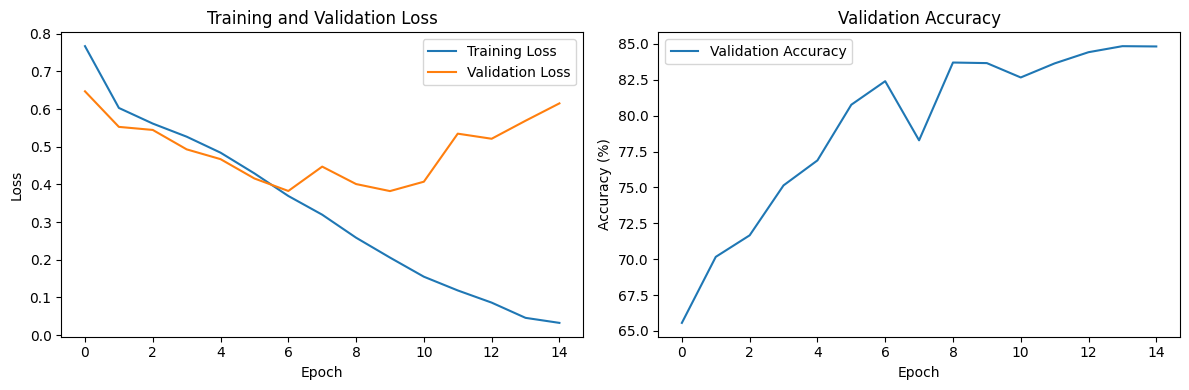

In [16]:
# 绘制训练过程
plt.figure(figsize=(12, 4))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

C:\Users\YI XIN\AppData\Local\Temp\ipykernel_7996\2936219007.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_attention_model.pth'

预测结果：这是一只猫
预测概率：100.00%


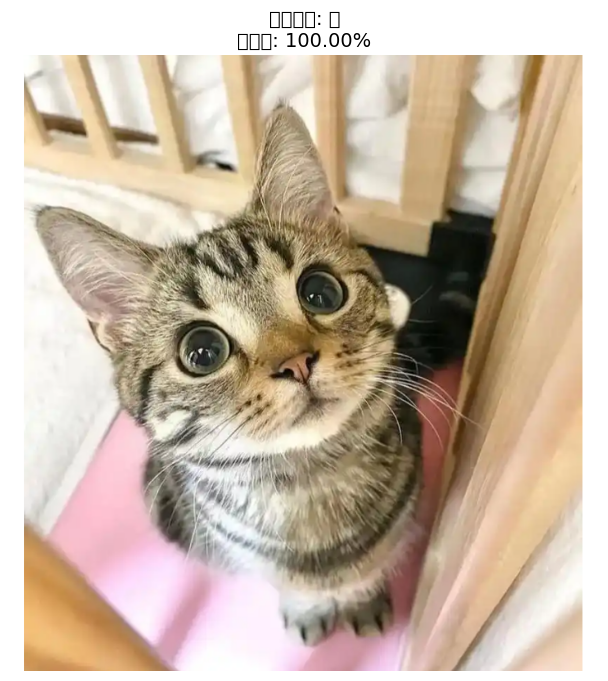

In [23]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def predict_single_image(image_path, model):
    # 确保模型处于评估模式
    model.eval()
    
    # 图像预处理
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # 加载并转换图像
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # 添加batch维度
    
    # 移动到GPU
    image_tensor = image_tensor.to(device)
    
    # 预测
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
    
    # 获取预测结果和概率
    pred_class = "猫" if predicted.item() == 0 else "狗"
    prob = probabilities[0][predicted.item()].item()
    print(f"预测结果：这是一只{pred_class}")
    print(f"预测概率：{prob*100:.2f}%")
    
    # 显示图像和预测结果
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'预测结果: {pred_class}\n置信度: {prob*100:.2f}%', fontsize=14)
    plt.show()
    
    return pred_class, prob

# 1. 首先创建模型实例
model = AttentionCNN().to(device)

# 2. 加载训练好的权重
model.load_state_dict(torch.load('best_attention_model.pth'))
# 使用示例
image_path = "D:/dogs-vs-cats/test1/159263.png"  # 替换为你要测试的图片路径
pred_class, probability = predict_single_image(image_path, model)

## 增加数据增强

In [4]:
# 1. 首先修改模型结构，添加更多正则化和残差连接
class ImprovedAttentionCNN(nn.Module):
    def __init__(self):
        super(ImprovedAttentionCNN, self).__init__()
        
        # 第一个卷积块
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )
        
        # 第二个卷积块（添加残差连接）
        self.conv2_main = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.conv2_shortcut = nn.Conv2d(32, 64, kernel_size=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # 改进的注意力机制
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(64, 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
        # 改进的分类头
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),  # 自适应池化到固定大小
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        # 第一个卷积块
        x = self.conv1(x)
        
        # 第二个卷积块（带残差连接）
        identity = self.conv2_shortcut(x)
        x = self.conv2_main(x)
        x = x + identity
        x = self.relu2(x)
        x = self.pool2(x)
        
        # 注意力机制
        ca = self.channel_attention(x)
        x = x * ca
        sa = self.spatial_attention(x)
        x = x * sa
        
        # 分类
        x = self.classifier(x)
        return x

# 2. 增强的数据增强策略
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# 3. 优化器和学习率策略
def get_optimizer_and_scheduler(model):
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.001,
        epochs=20,
        steps_per_epoch=len(train_loader),
        pct_start=0.3
    )
    
    return optimizer, scheduler

# 4. 改进的训练函数
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_valid_acc = 0
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
            
        # 验证阶段
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        valid_acc = 100. * correct / total
        
        # 保存最佳模型
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
import seaborn as sns

In [6]:
# 1. 首先定义改进的CNN模型
class ImprovedAttentionCNN(nn.Module):
    def __init__(self):
        super(ImprovedAttentionCNN, self).__init__()
        
        # 第一个卷积块
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )
        
        # 第二个卷积块（添加残差连接）
        self.conv2_main = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.conv2_shortcut = nn.Conv2d(32, 64, kernel_size=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # 改进的注意力机制
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(64, 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
        # 改进的分类头
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),  # 自适应池化到固定大小
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        # 第一个卷积块
        x = self.conv1(x)
        
        # 第二个卷积块（带残差连接）
        identity = self.conv2_shortcut(x)
        x = self.conv2_main(x)
        x = x + identity
        x = self.relu2(x)
        x = self.pool2(x)
        
        # 注意力机制
        ca = self.channel_attention(x)
        x = x * ca
        sa = self.spatial_attention(x)
        x = x * sa
        
        # 分类
        x = self.classifier(x)
        return x


In [7]:
# 2. 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# 3. 设置可视化风格
plt.style.use('seaborn')
sns.set_palette("husl")

C:\Users\YI XIN\AppData\Local\Temp\ipykernel_19232\3610654908.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [9]:
# 2. 实现改进的数据增强
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [10]:
# 3. 实现改进的训练和可视化函数
def train_and_visualize(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20):
    # 存储训练过程数据
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    best_valid_acc = 0
    patience = 5
    patience_counter = 0
    
    # 创建实时更新的图表
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # 验证阶段
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        epoch_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        accuracy = 100. * correct / total
        valid_accuracies.append(accuracy)
        
        # 更新学习率
        if scheduler is not None:
            scheduler.step(epoch_valid_loss)
        
        # 打印epoch结果
        print(f'\nEpoch [{epoch+1}/{num_epochs}] Summary:')
        print(f'Training Loss: {epoch_train_loss:.4f}')
        print(f'Validation Loss: {epoch_valid_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')
        print('-' * 60)
        
        # 更新图表
        ax1.clear()
        ax1.plot(train_losses, label='Training Loss')
        ax1.plot(valid_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Training and Validation Loss')
        
        ax2.clear()
        ax2.plot(valid_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.set_title('Validation Accuracy')
        
        plt.tight_layout()
        plt.draw()
        plt.pause(0.1)
        
        # 保存最佳模型
        if accuracy > best_valid_acc:
            best_valid_acc = accuracy
            torch.save(model.state_dict(), 'best_improved_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # 早停
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    plt.ioff()
    plt.show()
    
    return train_losses, valid_losses, valid_accuracies

In [11]:
# 4. 创建模型和优化器
model = ImprovedAttentionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

e:\Anaconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


开始训练...
Epoch [1/20], Step [100/625], Loss: 0.6886
Epoch [1/20], Step [200/625], Loss: 0.6791
Epoch [1/20], Step [300/625], Loss: 0.4582
Epoch [1/20], Step [400/625], Loss: 0.6328
Epoch [1/20], Step [500/625], Loss: 0.5748
Epoch [1/20], Step [600/625], Loss: 0.4505

Epoch [1/20] Summary:
Training Loss: 0.6138
Validation Loss: 0.5327
Validation Accuracy: 72.08%
------------------------------------------------------------


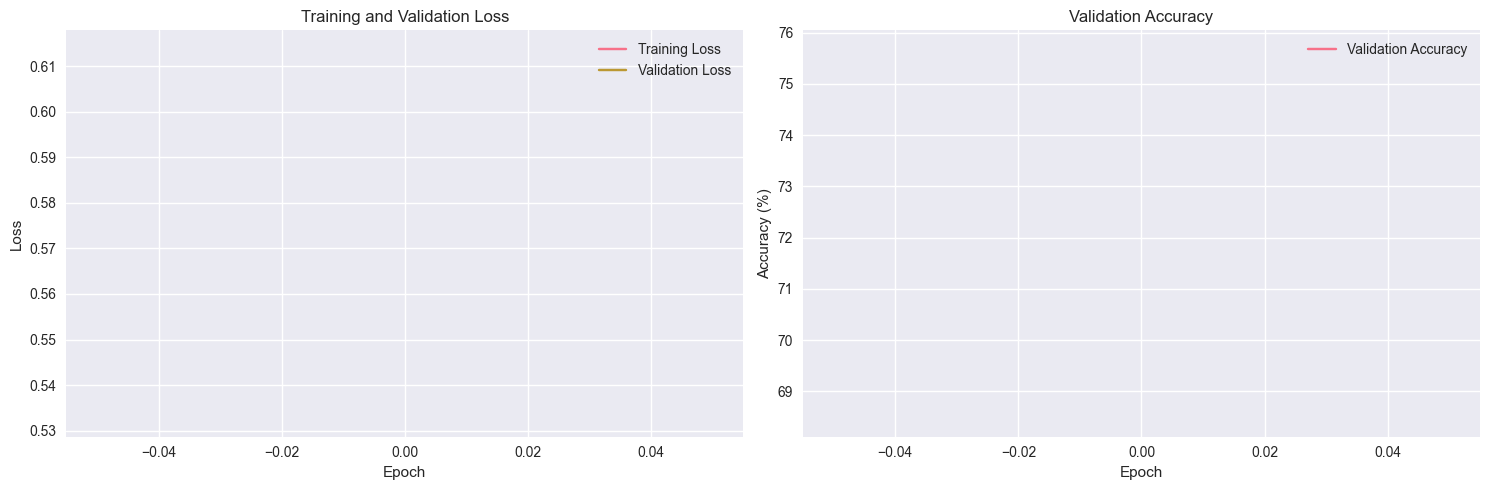

Epoch [2/20], Step [100/625], Loss: 0.7416
Epoch [2/20], Step [200/625], Loss: 0.6272
Epoch [2/20], Step [300/625], Loss: 0.4583
Epoch [2/20], Step [400/625], Loss: 0.5356
Epoch [2/20], Step [500/625], Loss: 0.6350
Epoch [2/20], Step [600/625], Loss: 0.4767

Epoch [2/20] Summary:
Training Loss: 0.5341
Validation Loss: 0.4848
Validation Accuracy: 76.06%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [3/20], Step [100/625], Loss: 0.7718
Epoch [3/20], Step [200/625], Loss: 0.4361
Epoch [3/20], Step [300/625], Loss: 0.5505
Epoch [3/20], Step [400/625], Loss: 0.5197
Epoch [3/20], Step [500/625], Loss: 0.5104
Epoch [3/20], Step [600/625], Loss: 0.5295

Epoch [3/20] Summary:
Training Loss: 0.4890
Validation Loss: 0.4559
Validation Accuracy: 78.28%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [4/20], Step [100/625], Loss: 0.4034
Epoch [4/20], Step [200/625], Loss: 0.4910
Epoch [4/20], Step [300/625], Loss: 0.3839
Epoch [4/20], Step [400/625], Loss: 0.5332
Epoch [4/20], Step [500/625], Loss: 0.4500
Epoch [4/20], Step [600/625], Loss: 0.4438

Epoch [4/20] Summary:
Training Loss: 0.4578
Validation Loss: 0.4177
Validation Accuracy: 80.12%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [5/20], Step [100/625], Loss: 0.5759
Epoch [5/20], Step [200/625], Loss: 0.3220
Epoch [5/20], Step [300/625], Loss: 0.6811
Epoch [5/20], Step [400/625], Loss: 0.5732
Epoch [5/20], Step [500/625], Loss: 0.4033
Epoch [5/20], Step [600/625], Loss: 0.3757

Epoch [5/20] Summary:
Training Loss: 0.4260
Validation Loss: 0.4104
Validation Accuracy: 81.04%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [6/20], Step [100/625], Loss: 0.3432
Epoch [6/20], Step [200/625], Loss: 0.2794
Epoch [6/20], Step [300/625], Loss: 0.3465
Epoch [6/20], Step [400/625], Loss: 0.2883
Epoch [6/20], Step [500/625], Loss: 0.6212
Epoch [6/20], Step [600/625], Loss: 0.4110

Epoch [6/20] Summary:
Training Loss: 0.4031
Validation Loss: 0.3876
Validation Accuracy: 82.28%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [7/20], Step [100/625], Loss: 0.5256
Epoch [7/20], Step [200/625], Loss: 0.4054
Epoch [7/20], Step [300/625], Loss: 0.4941
Epoch [7/20], Step [400/625], Loss: 0.3331
Epoch [7/20], Step [500/625], Loss: 0.6008
Epoch [7/20], Step [600/625], Loss: 0.4021

Epoch [7/20] Summary:
Training Loss: 0.3778
Validation Loss: 0.3680
Validation Accuracy: 83.98%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [8/20], Step [100/625], Loss: 0.3449
Epoch [8/20], Step [200/625], Loss: 0.3915
Epoch [8/20], Step [300/625], Loss: 0.3141
Epoch [8/20], Step [400/625], Loss: 0.2681
Epoch [8/20], Step [500/625], Loss: 0.4698
Epoch [8/20], Step [600/625], Loss: 0.3279

Epoch [8/20] Summary:
Training Loss: 0.3607
Validation Loss: 0.3505
Validation Accuracy: 84.90%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [9/20], Step [100/625], Loss: 0.4947
Epoch [9/20], Step [200/625], Loss: 0.4218
Epoch [9/20], Step [300/625], Loss: 0.2523
Epoch [9/20], Step [400/625], Loss: 0.2721
Epoch [9/20], Step [500/625], Loss: 0.2793
Epoch [9/20], Step [600/625], Loss: 0.4815

Epoch [9/20] Summary:
Training Loss: 0.3405
Validation Loss: 0.3473
Validation Accuracy: 84.08%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [10/20], Step [100/625], Loss: 0.1516
Epoch [10/20], Step [200/625], Loss: 0.5424
Epoch [10/20], Step [300/625], Loss: 0.2962
Epoch [10/20], Step [400/625], Loss: 0.4151
Epoch [10/20], Step [500/625], Loss: 0.4570
Epoch [10/20], Step [600/625], Loss: 0.3891

Epoch [10/20] Summary:
Training Loss: 0.3232
Validation Loss: 0.3310
Validation Accuracy: 85.60%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [11/20], Step [100/625], Loss: 0.5516
Epoch [11/20], Step [200/625], Loss: 0.2990
Epoch [11/20], Step [300/625], Loss: 0.1329
Epoch [11/20], Step [400/625], Loss: 0.2638
Epoch [11/20], Step [500/625], Loss: 0.1782
Epoch [11/20], Step [600/625], Loss: 0.3112

Epoch [11/20] Summary:
Training Loss: 0.3003
Validation Loss: 0.3335
Validation Accuracy: 85.56%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [12/20], Step [100/625], Loss: 0.2037
Epoch [12/20], Step [200/625], Loss: 0.6036
Epoch [12/20], Step [300/625], Loss: 0.3494
Epoch [12/20], Step [400/625], Loss: 0.2153
Epoch [12/20], Step [500/625], Loss: 0.2727
Epoch [12/20], Step [600/625], Loss: 0.2364

Epoch [12/20] Summary:
Training Loss: 0.2831
Validation Loss: 0.3456
Validation Accuracy: 85.34%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [13/20], Step [100/625], Loss: 0.1903
Epoch [13/20], Step [200/625], Loss: 0.6405
Epoch [13/20], Step [300/625], Loss: 0.2262
Epoch [13/20], Step [400/625], Loss: 0.1791
Epoch [13/20], Step [500/625], Loss: 0.4200
Epoch [13/20], Step [600/625], Loss: 0.3222

Epoch [13/20] Summary:
Training Loss: 0.2621
Validation Loss: 0.3319
Validation Accuracy: 86.48%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [14/20], Step [100/625], Loss: 0.0959
Epoch [14/20], Step [200/625], Loss: 0.2559
Epoch [14/20], Step [300/625], Loss: 0.3086
Epoch [14/20], Step [400/625], Loss: 0.3803
Epoch [14/20], Step [500/625], Loss: 0.1169
Epoch [14/20], Step [600/625], Loss: 0.1925

Epoch [14/20] Summary:
Training Loss: 0.2191
Validation Loss: 0.3219
Validation Accuracy: 87.10%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [15/20], Step [100/625], Loss: 0.1898
Epoch [15/20], Step [200/625], Loss: 0.1092
Epoch [15/20], Step [300/625], Loss: 0.3298
Epoch [15/20], Step [400/625], Loss: 0.2179
Epoch [15/20], Step [500/625], Loss: 0.1717
Epoch [15/20], Step [600/625], Loss: 0.1639

Epoch [15/20] Summary:
Training Loss: 0.2070
Validation Loss: 0.3253
Validation Accuracy: 87.18%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [16/20], Step [100/625], Loss: 0.3001
Epoch [16/20], Step [200/625], Loss: 0.1869
Epoch [16/20], Step [300/625], Loss: 0.2140
Epoch [16/20], Step [400/625], Loss: 0.1281
Epoch [16/20], Step [500/625], Loss: 0.1427
Epoch [16/20], Step [600/625], Loss: 0.1491

Epoch [16/20] Summary:
Training Loss: 0.1950
Validation Loss: 0.3274
Validation Accuracy: 87.32%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [17/20], Step [100/625], Loss: 0.1692
Epoch [17/20], Step [200/625], Loss: 0.2457
Epoch [17/20], Step [300/625], Loss: 0.0657
Epoch [17/20], Step [400/625], Loss: 0.1687
Epoch [17/20], Step [500/625], Loss: 0.4206
Epoch [17/20], Step [600/625], Loss: 0.4959

Epoch [17/20] Summary:
Training Loss: 0.1975
Validation Loss: 0.3301
Validation Accuracy: 87.18%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [18/20], Step [100/625], Loss: 0.3384
Epoch [18/20], Step [200/625], Loss: 0.2140
Epoch [18/20], Step [300/625], Loss: 0.1727
Epoch [18/20], Step [400/625], Loss: 0.0665
Epoch [18/20], Step [500/625], Loss: 0.1747
Epoch [18/20], Step [600/625], Loss: 0.3155

Epoch [18/20] Summary:
Training Loss: 0.1869
Validation Loss: 0.3306
Validation Accuracy: 87.48%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [19/20], Step [100/625], Loss: 0.0318
Epoch [19/20], Step [200/625], Loss: 0.1890
Epoch [19/20], Step [300/625], Loss: 0.1611
Epoch [19/20], Step [400/625], Loss: 0.2176
Epoch [19/20], Step [500/625], Loss: 0.0667
Epoch [19/20], Step [600/625], Loss: 0.0871

Epoch [19/20] Summary:
Training Loss: 0.1844
Validation Loss: 0.3273
Validation Accuracy: 87.38%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

Epoch [20/20], Step [100/625], Loss: 0.0406
Epoch [20/20], Step [200/625], Loss: 0.3922
Epoch [20/20], Step [300/625], Loss: 0.4060
Epoch [20/20], Step [400/625], Loss: 0.1317
Epoch [20/20], Step [500/625], Loss: 0.2780
Epoch [20/20], Step [600/625], Loss: 0.1954

Epoch [20/20] Summary:
Training Loss: 0.1806
Validation Loss: 0.3295
Validation Accuracy: 87.66%
------------------------------------------------------------


<Figure size 800x550 with 0 Axes>

In [17]:
# 5. 开始训练
print("开始训练...")
train_losses, valid_losses, valid_accuracies = train_and_visualize(
    model, train_loader, valid_loader, criterion, optimizer, scheduler
)

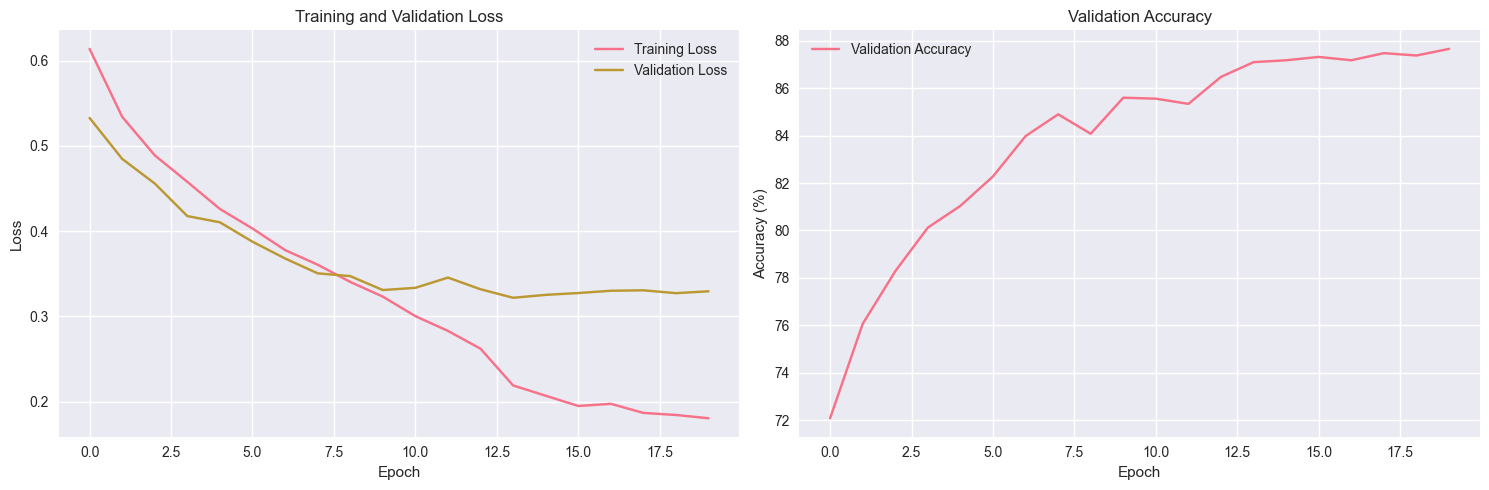

In [18]:
# 6. 保存最终的训练结果图
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()

### 测试best_improved_model.pth


In [12]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [13]:
def predict_single_image(image_path, model):
    # 确保模型处于评估模式
    model.eval()
    
    # 图像预处理
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # 加载并转换图像
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # 添加batch维度
    
    # 移动到GPU
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
    
    # 预测
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
    
    # 获取预测结果和概率
    pred_class = "猫" if predicted.item() == 0 else "狗"
    prob = probabilities[0][predicted.item()].item()
    
    # 显示图像和预测结果
    # 使用中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'预测结果: {pred_class}\n置信度: {prob*100:.2f}%', fontsize=14)
    plt.show()
    
    return pred_class, prob

C:\Users\YI XIN\AppData\Local\Temp\ipykernel_19232\3547245142.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_improved_model.pth')

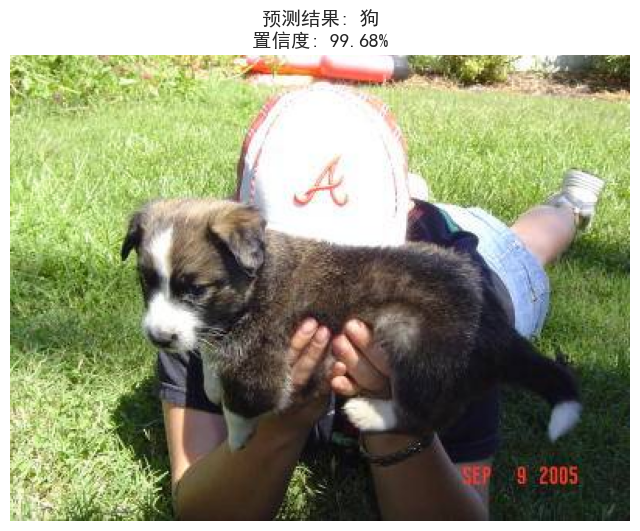

预测结果：这是一只 狗 
置信度： 99.68186616897583 %


In [19]:
image_path = "D:/dogs-vs-cats/test1/12490.jpg"
model = ImprovedAttentionCNN().to(device)
model.load_state_dict(torch.load('best_improved_model.pth'))
preed_class, probability = predict_single_image(image_path, model)
print("预测结果：这是一只",preed_class,"\n置信度：",probability*100,"%")